In [ ]:
# !pip install -q transformers peft datasets evaluate accelerate torch scikit-learn
# !pip install -U git+https://github.com/huggingface/accelerate.git
# !pip install -U git+https://github.com/huggingface/transformers.git
# !pip install tensorflow
# !pip install -U datasets huggingface_hub fsspec
# !pip install peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.0 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-60gmtbbm
  Running command git clone --filter

## Imports

In [3]:
import torch
import tensorflow.compat.v1 as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig, AutoPeftModelForSequenceClassification
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Loading and Evaluating a Foundation Model

## Loading the model, tokenizer, dataset

In [4]:
def set_seed(seed: int):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 42
set_seed(SEED)
print(f"Random seed set to {SEED}")

Random seed set to 42


### Load dataset

In [10]:
print("Loading IMDb dataset...")
dataset = load_dataset("imdb")
print("IMDb dataset loaded.")
print(f"Dataset structure: {dataset}")

Loading IMDb dataset...
IMDb dataset loaded.
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


### Load and Train Tokenizer

In [11]:
print("Initializing GPT2Tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print(f"Tokenizer padding side set to: {tokenizer.padding_side}")
print(f"Tokenizer pad token set to: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")

Initializing GPT2Tokenizer...
Tokenizer padding side set to: left
Tokenizer pad token set to: <|endoftext|> (ID: 50256)


In [12]:
# Define a preprocessing function to tokenize the text and truncate sequences
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

# Apply the preprocessing function to the dataset
print("Tokenizing dataset...")
tokenized_dataset = dataset.map(preprocess_function, batched=True)
print("Dataset tokenization complete.")

# Rename the 'label' column to 'labels' as expected by the Trainer
tokenized_dataset = tokenized_dataset.rename_columns({"label": "labels"})

# Remove the original 'text' column as it's no longer needed
tokenized_dataset = tokenized_dataset.remove_columns(["text"])

# Create a DataCollatorWithPadding for dynamic padding
# This is more efficient than padding the entire dataset to maximum length.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print("DataCollatorWithPadding initialized.")


Tokenizing dataset...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset tokenization complete.
DataCollatorWithPadding initialized.


In [13]:
train_dataset = tokenized_dataset["train"]
test_dataset = tokenized_dataset["test"]
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 25000
Test dataset size: 25000


### Model and Tokenizer Setup

In [14]:
# Load model

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "gpt2",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)
print("AutoModelForSequenceClassification model loaded.")

# Set the model's padding token ID to match the tokenizer's end-of-sequence token.
# This ensures consistency between the tokenizer and the model's internal padding handling.
model.config.pad_token_id = tokenizer.eos_token_id
print(f"Model's pad_token_id set to: {model.config.pad_token_id}")


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AutoModelForSequenceClassification model loaded.
Model's pad_token_id set to: 50256


In [15]:
# Define a compute_metrics function that calculates accuracy, precision, recall, and F1-score
def compute_metrics(p):
    predictions, labels = p
    # For binary classification, apply argmax to get the predicted class
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [16]:
# Define training hyperparameters
output_dir = "./results/baseline_model_evaluation "
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir=f"{output_dir}/logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
)
print("Training arguments defined.")

# Initialize the Trainer class
print("Initializing Trainer...")
baseline_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
print("Trainer initialized.")

# Start training
print("Starting training...")

baseline_eval_results = baseline_trainer.evaluate()
print(f"Evaluation baseline model results: {baseline_eval_results}")

baseline_trainer.train()

print("Training complete.")

Training arguments defined.
Initializing Trainer...


/tmp/ipython-input-16-1968240292.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(


Trainer initialized.
Starting training...


Evaluation baseline model results: {'eval_loss': 2.7966880798339844, 'eval_model_preparation_time': 0.0022, 'eval_accuracy': 0.50196, 'eval_precision': 0.5243296921549155, 'eval_recall': 0.04224, 'eval_f1': 0.07818168357148145, 'eval_runtime': 394.0912, 'eval_samples_per_second': 63.437, 'eval_steps_per_second': 3.966}


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.409600,0.237381,0.002200,0.906080,0.903369,0.909440,0.906395


Training complete.


## Train the Model

In [17]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=4,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["c_attn", "c_proj", "c_fc"]
)

print("LoRA configuration defined:")
print(lora_config)

# # Wrap the AutoModelForSequenceClassification model with the LoraConfig using get_peft_model()
model = get_peft_model(model, lora_config)
print("PEFT model created with LoRA.")

# Print the number of trainable parameters
model.print_trainable_parameters()

LoRA configuration defined:
LoraConfig(task_type=<TaskType.SEQ_CLS: 'SEQ_CLS'>, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=4, target_modules={'c_attn', 'c_fc', 'c_proj'}, exclude_modules=None, lora_alpha=32, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)
PEFT model created with LoRA.
trainable params: 591,360 || all params: 125,032,704 || trainable%: 0.4730


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [18]:
# Define training hyperparameters
output_dir = "./results/peft"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir=f"{output_dir}/logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
)
print("Training arguments defined.")

# Initialize the Trainer class
print("Initializing Trainer...")
peft_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
print("Trainer initialized.")

# Start training
print("Starting training...")

peft_eval_results = peft_trainer.evaluate()
print(f"Evaluation peft model results: {peft_eval_results}")

peft_trainer.train()

print("Training complete.")

/tmp/ipython-input-18-1291641688.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  peft_trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training arguments defined.
Initializing Trainer...
Trainer initialized.
Starting training...


Evaluation peft model results: {'eval_loss': 0.23738054931163788, 'eval_model_preparation_time': 0.0063, 'eval_accuracy': 0.90608, 'eval_precision': 0.9033693579148124, 'eval_recall': 0.90944, 'eval_f1': 0.9063945144315101, 'eval_runtime': 495.9601, 'eval_samples_per_second': 50.407, 'eval_steps_per_second': 3.151}


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.264300,0.243068,0.006300,0.905440,0.890447,0.924640,0.907221


Training complete.


### Evaluating the model

Evaluation base model results: {'eval_loss': 2.7966880798339844, 'eval_model_preparation_time': 0.0022, 'eval_accuracy': 0.50196, 'eval_precision': 0.5243296921549155, 'eval_recall': 0.04224, 'eval_f1': 0.07818168357148145, 'eval_runtime': 394.0912, 'eval_samples_per_second': 63.437, 'eval_steps_per_second': 3.966}
Evaluation peft model results: {'eval_loss': 0.23738054931163788, 'eval_model_preparation_time': 0.0063, 'eval_accuracy': 0.90608, 'eval_precision': 0.9033693579148124, 'eval_recall': 0.90944, 'eval_f1': 0.9063945144315101, 'eval_runtime': 495.9601, 'eval_samples_per_second': 50.407, 'eval_steps_per_second': 3.151}



Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.89      0.90     12500
    Positive       0.89      0.92      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000



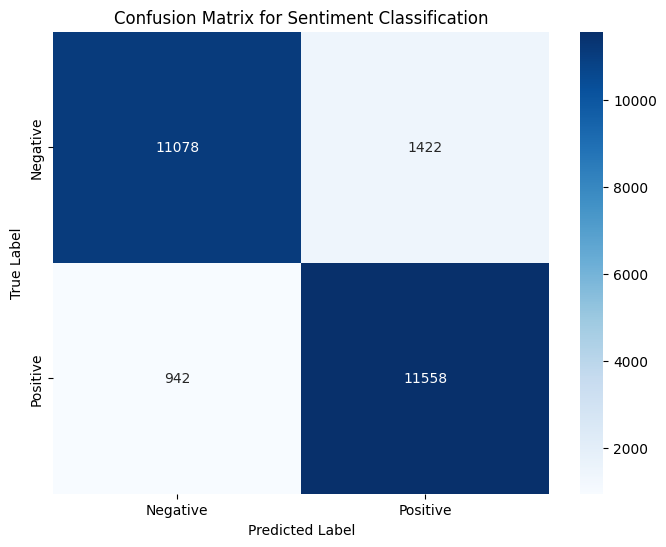

Confusion matrix plotted.


In [21]:
print(f"Evaluation base model results: {baseline_eval_results}")
print(f"Evaluation peft model results: {peft_eval_results}")

# Generate predictions for classification report and confusion matrix
predictions_output = peft_trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Use classification_report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Negative", "Positive"]))

# Plot a confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Sentiment Classification")
plt.show()
print("Confusion matrix plotted.")

## Saving and Loading PEFT Adapter

In [23]:
# Demonstrate how to save the lightweight PEFT adapter
peft_model_id = os.path.join(output_dir, "save_peft")
print(f"Saving PEFT adapter to: {peft_model_id}")
peft_trainer.model.save_pretrained(peft_model_id)
tokenizer.save_pretrained(peft_model_id) # Save tokenizer as well for consistency
print("PEFT adapter and tokenizer saved.")

# Demonstrate how it can be loaded later
print(f"Loading PEFT adapter from: {peft_model_id}")

Saving PEFT adapter to: ./results/peft/save_peft
PEFT adapter and tokenizer saved.
Loading PEFT adapter from: ./results/peft/save_peft


In [25]:
# Define training hyperparameters
output_dir = "./results/finetune"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir=f"{output_dir}/logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
)
print("Training arguments defined.")

# Initialize the Trainer class
print("Initializing Trainer...")
finetune_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
print("Trainer initialized.")

# Start training
print("Starting training...")

finetune_eval_results = finetune_trainer.evaluate()
print(f"Evaluation peft model results: {finetune_eval_results}")

finetune_trainer.train()

print("Training complete.")

/tmp/ipython-input-25-3720880371.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  finetune_trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training arguments defined.
Initializing Trainer...
Trainer initialized.
Starting training...


Evaluation peft model results: {'eval_loss': 0.2430676817893982, 'eval_model_preparation_time': 0.006, 'eval_accuracy': 0.90544, 'eval_precision': 0.890446841294299, 'eval_recall': 0.92464, 'eval_f1': 0.9072213500784929, 'eval_runtime': 498.8656, 'eval_samples_per_second': 50.114, 'eval_steps_per_second': 3.133}


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.258800,0.240679,0.006000,0.908440,0.894704,0.925840,0.910006


Training complete.


In [26]:
# Load the PEFT adapter
loaded_peft_model = AutoPeftModelForSequenceClassification.from_pretrained(peft_model_id)

print("PEFT adapter successfully loaded for inference demonstration.")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT adapter successfully loaded for inference demonstration.


In [27]:
# # loaded_peft_model for inference.
text = "This movie was absolutely fantastic! I loved every minute of it."
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs = loaded_peft_model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    print(f"Review: '{text}' -> Predicted Sentiment: {loaded_peft_model.config.id2label[predicted_class_id]}")


Review: 'This movie was absolutely fantastic! I loved every minute of it.' -> Predicted Sentiment: LABEL_0
